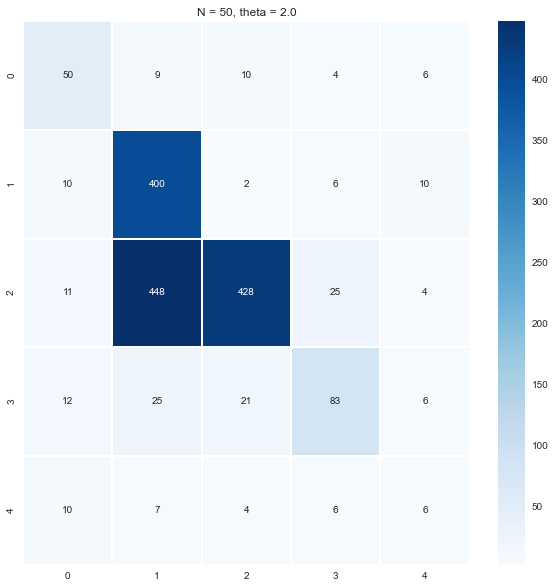

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use("seaborn")

a = 2.46 # angstrom
angle = 2.0
theta  = angle*np.pi/180 # degree to rad

# primitive vectors of SLG by Moon Koshino (2013)
#lat_vec1 = a*np.array([1,0])
#lat_vec2 = a*np.array([0.5,0.5*np.sqrt(3)])

lat_vec1 = a*np.array([0.5,0.5*np.sqrt(3)])
lat_vec2 = a*np.array([-0.5,0.5*np.sqrt(3)])

N = 50

def Rotation(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c, -s), (s, c)))

lat_vec_bottom1 = np.matmul(Rotation(-0.5*theta), lat_vec1)
lat_vec_bottom2 = np.matmul(Rotation(-0.5*theta), lat_vec2)
lat_vec_top1 = np.matmul(Rotation(0.5*theta), lat_vec1)
lat_vec_top2 = np.matmul(Rotation(0.5*theta), lat_vec2)

d0 = 3.35 # angstrom
a0 = 1.42 # angstrom
tau = a0*np.array([0,1]) # shift from A to B

def DistBottomTop(bottom_atom, sublattice_bottom, top_atom, sublattice_top):

    # bottom_atom and top_atom are indices [i,j] and [n,k] of lattice elements
    # sublattice =0 stands for A, =1 stands for B
    # returns distance between given atoms
    
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2
    vec_top_atom = top_atom[0]*lat_vec_top1+top_atom[1]*lat_vec_top2
    if sublattice_bottom == sublattice_top:
        return np.sqrt(np.linalg.norm(vec_bottom_atom-vec_top_atom)**2+d0**2)
    elif sublattice_bottom == 0:
        return np.sqrt(np.linalg.norm(vec_bottom_atom-vec_top_atom-tau)**2+d0**2)
    elif sublattice_bottom == 1:
        return np.sqrt(np.linalg.norm(vec_bottom_atom-vec_top_atom+tau)**2+d0**2)
    

#print(DistBottomTop([0,0],1,[0,5],1))

def ExtractFirsts(lst):
    return [item[0] for item in lst]



def ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top):
    
    # finds [n,k] of atom from top layer within given sublattice
    # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
    # returns distance to closest atom, its coordinates and vector in plane which connects bottom atom to top atom
    
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2 + 0.5*(2*sublattice_bottom-1)*tau
    dists = []
    window = int(1.1*theta*N) # a window which helps to shorten the area of searching for closest atom
    for n in range(bottom_atom[0]-window, bottom_atom[0]+window):
        for k in range(bottom_atom[1]-window, bottom_atom[1]+window):
            vec_top_atom = n*lat_vec_top1+k*lat_vec_top2 + 0.5*(2*sublattice_top-1)*tau
            dists.append([DistBottomTop(vec_bottom_atom,sublattice_bottom, vec_top_atom,sublattice_top),[n,k]])
    distances = ExtractFirsts(dists)
    index = np.argmin(np.array(distances))
    vec_top_atom = dists[index][1][0]*lat_vec_top1+dists[index][1][1]*lat_vec_top2 + 0.5*(2*sublattice_top-1)*tau
    delta = vec_top_atom-vec_bottom_atom
    return [dists[index],delta]

def ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):
    
    # finds [n,k] of atom from top layer within given sublattice
    # which is the closest to given [i,j] atom from sublattice_bottom from the bottom
    # returns distance to closest atom, its coordinates and vector in plane which connects bottom atom to top atom
    # uses aim (closest atom calculated in previous step) and the window=4 for searching the next closest atom
    
    vec_bottom_atom = bottom_atom[0]*lat_vec_bottom1+bottom_atom[1]*lat_vec_bottom2 + 0.5*(2*sublattice_bottom-1)*tau
    dists = []
    window = 4 # a largest possible shift in indices when the previous closest atom is known
    for n in range(aim_atom[0]-window, aim_atom[0]+window+1):
        for k in range(aim_atom[1]-window, aim_atom[1]+window+1):
            vec_top_atom = n*lat_vec_top1+k*lat_vec_top2 + 0.5*(2*sublattice_top-1)*tau
            dists.append([DistBottomTop(vec_bottom_atom,sublattice_bottom, vec_top_atom,sublattice_top),[n,k]])
    distances = ExtractFirsts(dists)
    index = np.argmin(np.array(distances))
    vec_top_atom = dists[index][1][0]*lat_vec_top1+dists[index][1][1]*lat_vec_top2 + 0.5*(2*sublattice_top-1)*tau
    delta = vec_top_atom-vec_bottom_atom
    return [dists[index],delta]

#print(ClosestAtomFromTop([4,2],0,0))

Vppsigma = 0.48 # eV
Vpppi = -2.7 # eV
delta0 = 0.184*a # angstrom 
h0 = 3.349 # angstrom
rc = 6.14 # angstrom
lc = 0.265 # angstrom

def Hopping(vec, sublattice_bottom, sublattice_top):
    
    # vec is a vector connecting grid elements from bottom and top layer in 2D (top minus bottom)
    # returns value -t(d) following Moon Koshino (2013)
    
    vec = vec + (sublattice_top-sublattice_bottom)*tau
    full_dist = np.sqrt(np.linalg.norm(vec)**2+d0**2)
    Vpi = Vpppi*np.exp(-(full_dist-a0)/delta0)
    Vsigma = Vppsigma*np.exp(-(full_dist-d0)/delta0)
    return Vpi*(1-(d0/full_dist)**2)+Vsigma*(d0/full_dist)**2

#Hopping([-0,0],0,0)

G1M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*np.array([1,0])
G2M = 8*np.pi/(np.sqrt(3)*a)*np.sin(0.5*theta)*np.array([-0.5,0.5*np.sqrt(3)])

K = 2*np.pi/a*np.array([2/3,0]) # here - is for K and + is for K'

def HamiltForK(bottom_atom, sublattice_bottom, sublattice_top):
    
    # bottom atom is an array [i,j]
    # tight-binding model with hoppings to 9 closest neighbours
    # returns value of hamiltonian matrix element between bloch states
    # with given wave number K from Dirac point

    top_atom = ClosestAtomFromTop(bottom_atom, sublattice_bottom, sublattice_top)
    delta = top_atom[1]
    ham = 0
    for i in np.arange(-1,2):
        for j in np.arange(-1,2):
            vec = delta + i*lat_vec_bottom1 + j*lat_vec_bottom2
#vec = delta + i*lat_vec_top1 + j*lat_vec_top2
            phase = -np.dot(K, vec)
            ham += Hopping(vec,0,0)*np.exp(1.j*phase) # delta knows about sublattices indices hence 0,0 in this formula
    return [ham, top_atom]


def HamiltForKAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top):
    
    # bottom atom is an array [i,j]
    # tight-binding model with hoppings to 9 closest neighbours
    # returns value of hamiltonian matrix element between bloch states
    # with given wave number K from Dirac point

    top_atom = ClosestAtomFromTopAimed(aim_atom, bottom_atom, sublattice_bottom, sublattice_top)
    delta = top_atom[1]
    ham = 0
    for i in np.arange(-1,2):
        for j in np.arange(-1,2):
            vec = delta + i*lat_vec_bottom1 + j*lat_vec_bottom2
#vec = delta + i*lat_vec_top1 + j*lat_vec_top2
            phase = -np.dot(K, vec)
            ham += Hopping(vec,0,0)*np.exp(1.j*phase) # delta knows about sublattices indices hence 0,0 in this formula
    return [ham, top_atom]
        
#HamiltForK([0,5],0,0)

def FourierHopping(moire_vec, sublattice_bottom, sublattice_top):
    
    # moire vec is described by an array [n,k] and equals n*G1M+k*G2M
    # returns fourier amplitude of hopping function
    
    ampl = 0
    flag = 0

    for n in np.arange(-N, N+1):
        for k in np.arange(-N, N+1):
            if flag==0:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2 
                hamiltonian = HamiltForK([n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = -np.dot(G, vec_bottom_atom) # phase before delta may be - or +
                ampl += hopping*np.exp(1.j*phase)
                flag = 1 
            else:
                vec_bottom_atom = n*lat_vec_bottom1+k*lat_vec_bottom2 
                hamiltonian = HamiltForKAimed(aim_atom, [n,k], sublattice_bottom, sublattice_top)
                hopping = hamiltonian[0]
                top_atom = hamiltonian[1]
                aim_atom = top_atom[0][1]
                G = moire_vec[0]*G1M + moire_vec[1]*G2M
                phase = np.dot(G, vec_bottom_atom)
                ampl += hopping*np.exp(1.j*phase)
    return np.abs(ampl)

FourierAmpls = np.zeros((5,5))

for i in np.arange(-2,3):
    for j in np.arange(-2,3):
        FourierAmpls[i+2,j+2] = int(FourierHopping([i,j],0,0))


plt.figure(figsize=(10,10))
heat_map = sns.heatmap(FourierAmpls, linewidth = 1 , annot = True, cmap="Blues", fmt = ".3g")
plt.title( "N = " + str(N) + ", theta = " + str(angle) )
plt.show()


In [29]:
FourierAmpls

array([[  1.,   1.,   0.,   2.,   1.],
       [  1.,   1.,   0.,  16.,   4.],
       [  8.,   3.,   1.,   1.,   5.],
       [  2.,   1.,   1., 127.,   6.],
       [  2.,   2.,   5.,   4.,  10.]])

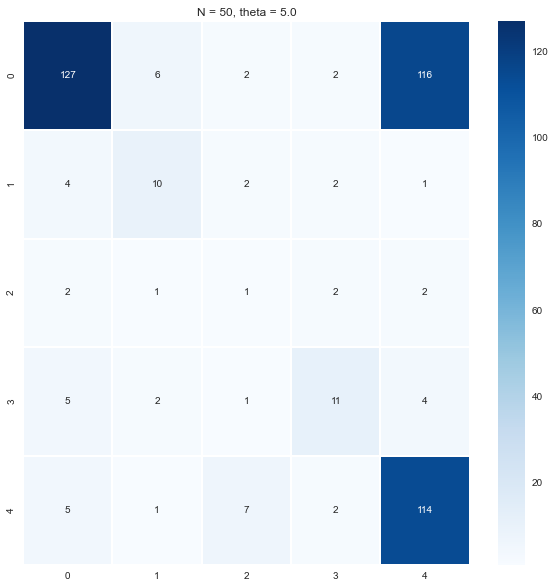

In [27]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap(FourierAmpls, linewidth = 1 , annot = True, cmap="Blues", fmt = ".3g")
plt.title( "N = " + str(N) + ", theta = " + str(angle) )
plt.show()

In [33]:
data = readmatrix('sigma_xx.csv')

NameError: name 'readmatrix' is not defined